# Выпускной проект: "Промышленность (прогнозирование температуры стали)"



Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План работы

1. Провести разведывательный анализ данных
2. Подготовить данные. 
    - Изменить типы данных где необходимо 
    - создать новые признаки
    - удалить ненужные признаки
    - обработать пропуски
    - по необходимости сделать сводные таблицы
    - создать единую таблицу ср всеми необходимыми данными
    - и т.д. по необходимости
3. создать и натренировать модели:
    - константная модель
    - линейная модель
    - CatBoost
4. Оценить эффективность моделей на тестовой выборке
5. Сделать вывод

# Подготовительный этап

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
RANDOM_STATE = 80523
CV_COUNT = 5
TEST_SIZE = 0.25

# Разведывательный анализ данных

In [3]:
#  Загрузим данные
df_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
df_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
df_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
df_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
df_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
df_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
df_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

## Данные об электродах

In [4]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [5]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [6]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
df_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

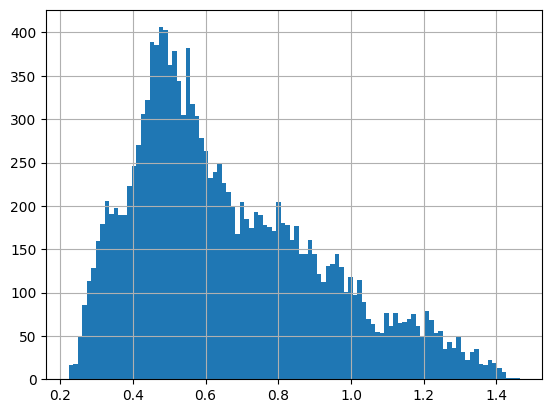

In [8]:
df_arc['Активная мощность'].hist(bins=100);

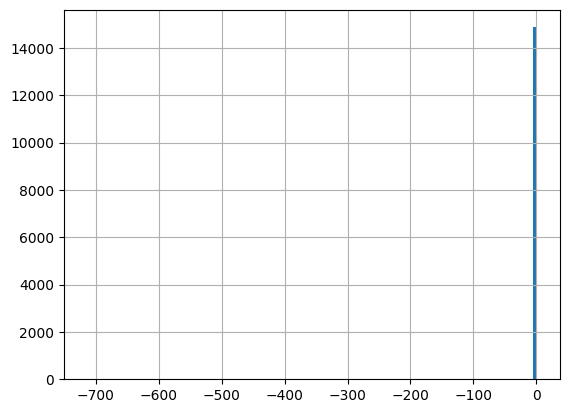

In [9]:
df_arc['Реактивная мощность'].hist(bins=100);

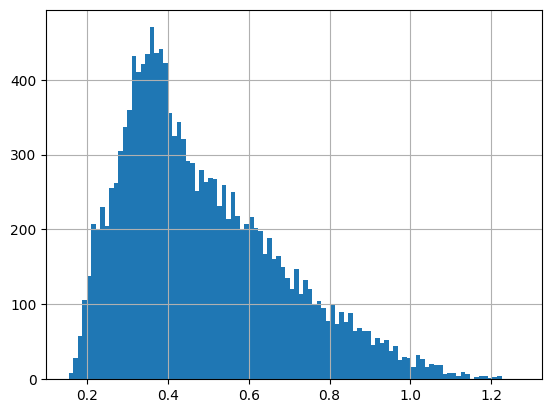

In [10]:
df_arc[df_arc['Реактивная мощность'] >=0]['Реактивная мощность'].hist(bins=100);

In [11]:
df_arc[df_arc['Реактивная мощность'] <0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


<u>ВЫВОД</u>

1. есть информация о 3214 партиях стали
2. у полей `Начало нагрева дугой` и `Конец нагрева дугой` нужно поменять тип
3. пропусков нет 
4. в поле `Реактивная мощность` есть один очевидный выброс -715.479924, его нужно удалить


## Данные о подаче сыпучих материалов (объём)

In [12]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


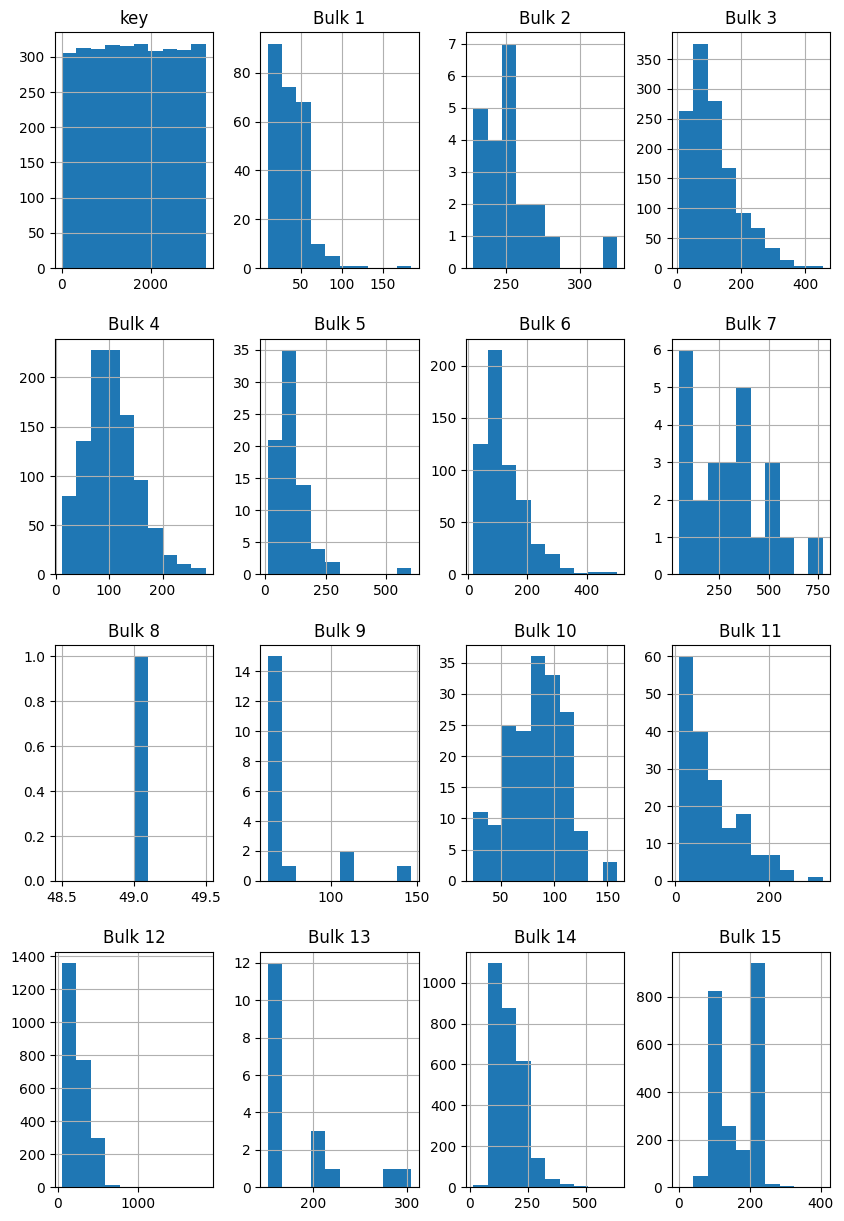

In [13]:
df_bulk.hist(figsize=(10, 15));

In [14]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [15]:
df_bulk['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

In [16]:
# Посмотрим пропуски
pd.DataFrame({'count':df_bulk.isna().sum(), '%':df_bulk.isna().mean()*100}).sort_values(by='%', ascending=False).style.background_gradient('coolwarm').format({"%": "{:.2f}"})

,count,%
Bulk 8,3128,99.97
Bulk 13,3111,99.42
Bulk 9,3110,99.39
Bulk 2,3107,99.30
Bulk 7,3104,99.20
Bulk 5,3052,97.54
Bulk 10,2953,94.38
Bulk 11,2952,94.34
Bulk 1,2877,91.95
Bulk 6,2553,81.59


<u>ВЫВОД</u>

1. есть информация о 3129 партиях стали
2. в данных много пропусков (нужно будет заполнить нулями)
3. поскольку от заказцика нет информации, что считать выбросами, то соответственно никакие данные удалять не будем

## Данные о подаче сыпучих материалов (время)

In [17]:
df_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


<u>ВЫВОД</u>

Поскольку данные о времени когда именно была добавлена та или иная добавка в расплав стали для нашей модели бесполезна (по согласованию с заказчиком и исходя из физической сути процесса), то данныке из этого датасета в дальнейшем использовать не будем

## Данные о продувке сплава газом

In [18]:
df_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [19]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [20]:
df_gas['key'].nunique()

3239

In [21]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


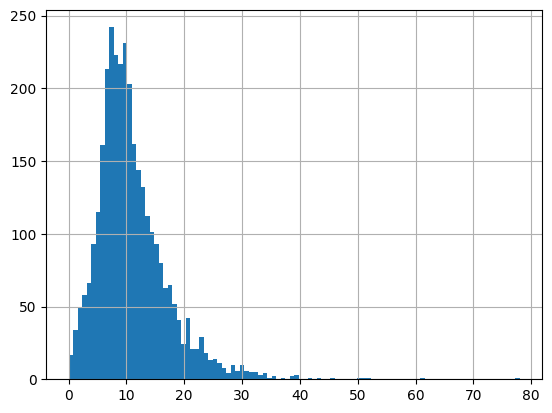

In [22]:
df_gas['Газ 1'].hist(bins=100);

<u>ВЫВОД</u>
1. есть информация о 3239 партиях стали
1. в данных нет пропусков
1. очевидных выбросов нет

## Результаты измерения температуры

In [23]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [24]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [25]:
df_temp['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

In [26]:
df_temp['Температура'].isna().sum()

3427

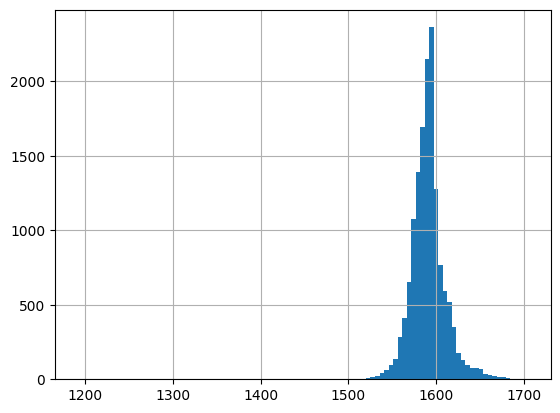

In [27]:
df_temp['Температура'].hist(bins=100);

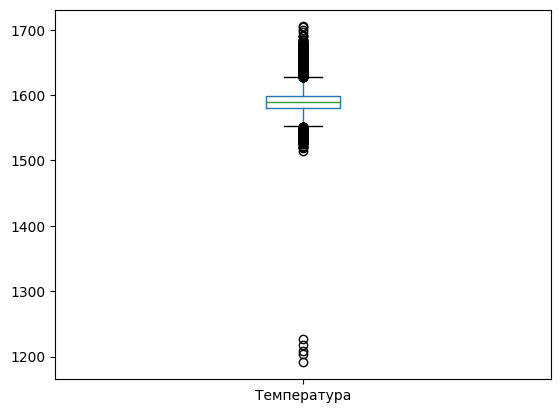

In [28]:
df_temp['Температура'].plot.box();

<u>ВЫВОД</u>
1. есть информация о 3216 партиях стали
1. в данных 3427 пропусков
1. есть выбросы (низкие температуры около 1200)

## Данные о проволочных материалах (объём)

In [29]:
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


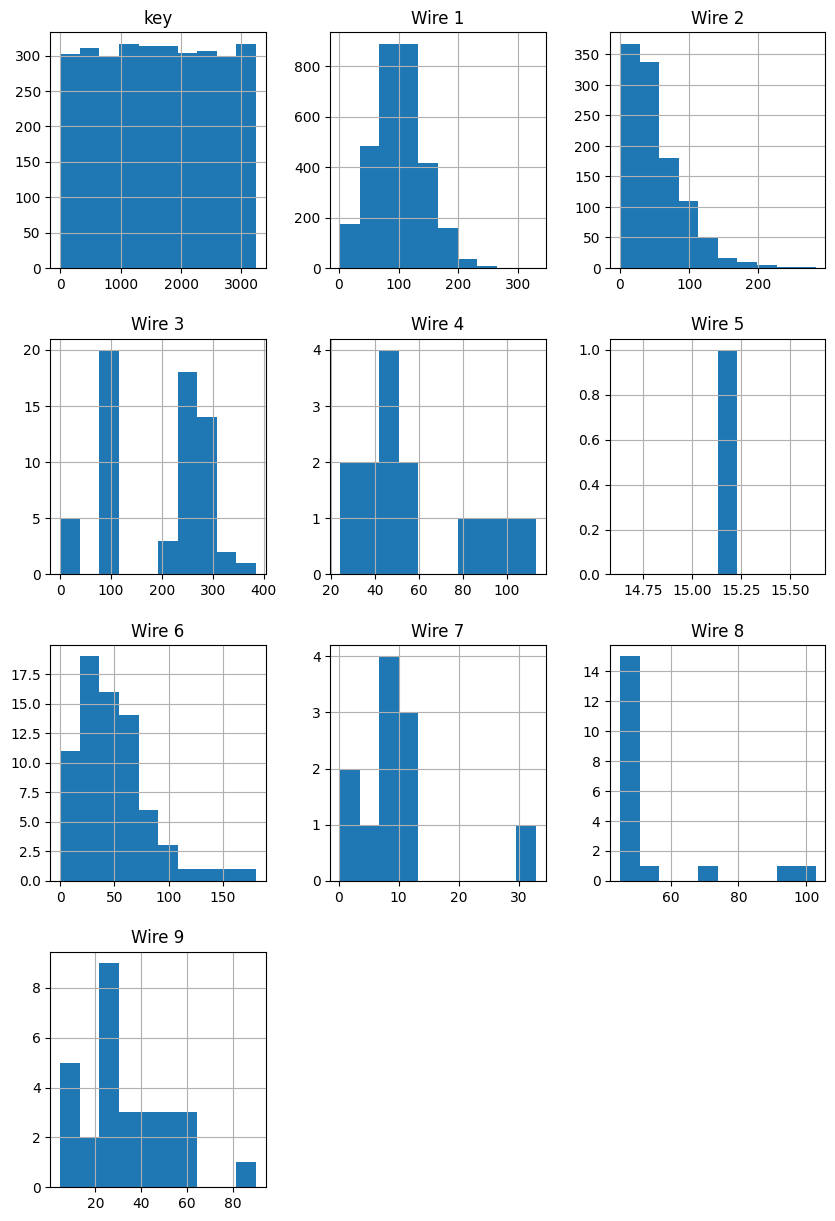

In [30]:
df_wire.hist(figsize=(10, 15));

In [31]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [32]:
df_wire['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

In [33]:
# Посмотрим пропуски
pd.DataFrame({'count':df_wire.isna().sum(), '%':df_wire.isna().mean()*100}).sort_values(by='%', ascending=False).style.background_gradient('coolwarm').format({"%": "{:.2f}"})

,count,%
Wire 5,3080,99.97
Wire 7,3070,99.64
Wire 4,3067,99.55
Wire 8,3062,99.38
Wire 9,3052,99.06
Wire 3,3018,97.96
Wire 6,3008,97.63
Wire 2,2002,64.98
Wire 1,26,0.84
key,0,0.00


<u>ВЫВОД</u>

1. есть информация о 3081 партиях стали
2. в данных много пропусков (нужно будет заполнить нулями)
3. поскольку от заказцика нет информации, что считать выбросами, то соответственно никакие данные удалять не будем

## Данные о проволочных материалах (время)

In [34]:
df_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<u>ВЫВОД</u>

Поскольку данные о времени когда именно была добавлена та или иная добавка в расплав стали для нашей модели бесполезна (по согласованию с заказчиком и исходя из физической сути процесса), то данныке из этого датасета в дальнейшем использовать не будем

## Данные об электродах

In [35]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [36]:
# переведем данные по времени в соответствующий формат
df_arc[["Начало нагрева дугой", "Конец нагрева дугой"]] = df_arc[["Начало нагрева дугой", "Конец нагрева дугой"]].apply(pd.to_datetime)

# создадим признак длительности нагрева и удалим ставшие ненужными признаки
df_arc['heating_time'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.total_seconds().astype(int)
df_arc = df_arc.drop(columns=['Начало нагрева дугой', 'Конец нагрева дугой'])

# создадим сводную таблицу сгруппировав данные по номеру партии и получив средние по мощностям и количество циклов в каждой партии 
df_arc = df_arc.groupby('key')[['heating_time', 
                                'Активная мощность', 
                                'Реактивная мощность']].agg({'heating_time': ['count', 'sum'], 
                                                             'Активная мощность': ['mean'],
                                                             'Реактивная мощность': ['mean']})

# сделаем заголовки у сводной таблицы одноуровневыми
df_arc.columns = ['_'.join(col).strip() for col in df_arc.columns.values]

# финальный датасет
df_arc

,heating_time_count,heating_time_sum,Активная мощность_mean,Реактивная мощность_mean
key,,,,
1,5,1098,0.607346,0.428564
2,4,811,0.534852,0.363339
3,5,655,0.812728,0.587491
4,4,741,0.676622,0.514248
5,4,869,0.563238,0.421998
...,...,...,...,...
3237,5,909,0.508374,0.405083
3238,3,546,0.458274,0.346034
3239,8,1216,0.606001,0.442693


In [37]:
df_arc.describe()

,heating_time_count,heating_time_sum,Активная мощность_mean,Реактивная мощность_mean
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,4.628500,794.579029,0.661331,0.430279
std,1.608647,332.448622,0.128372,3.158514
min,1.000000,57.000000,0.267676,-178.491508
25%,4.000000,571.000000,0.573035,0.417301
50%,4.000000,770.000000,0.652974,0.481508
75%,6.000000,983.000000,0.739388,0.543312
max,16.000000,4189.000000,1.243889,0.960763


In [38]:
# удалим аномалию с отрицательной мощностью
df_arc = df_arc[df_arc['Реактивная мощность_mean'] > 0]
df_arc.describe()

,heating_time_count,heating_time_sum,Активная мощность_mean,Реактивная мощность_mean
count,3213.000000,3213.000000,3213.000000,3213.000000
mean,4.628696,794.691566,0.661332,0.485966
std,1.608860,332.439136,0.128392,0.097600
min,1.000000,57.000000,0.267676,0.196228
25%,4.000000,571.000000,0.573010,0.417393
50%,4.000000,770.000000,0.652864,0.481626
75%,6.000000,983.000000,0.739401,0.543327
max,16.000000,4189.000000,1.243889,0.960763


## Данные о подаче сыпучих материалов (объём)

In [39]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [40]:
# заполним пропуски
df_bulk = df_bulk.fillna(0)

# для дальнейшего объединения датасетов сделам ключ партии индексом
df_bulk = df_bulk.set_index('key')

# финальный датасет
df_bulk

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0


## Данные о продувке сплава газом

In [41]:
df_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [42]:
# для дальнейшего объединения датасетов сделам ключ партии индексом
df_gas = df_gas.set_index('key')

# финальный датасет
df_gas

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692
...,...
3237,5.543905
3238,6.745669
3239,16.023518


## Результаты измерения температуры

In [43]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [44]:
# удалим бесполезный признак
df_temp = df_temp.drop(columns=['Время замера'])

# заполним пропуски в температуре нулями, 
# нули меньше 1500 (допустимые температуры по условию заказчика)
# и в дальнейшем после группировки мы удалим из сводной таблицы целиком партии 
# в которых первая или последняя температура меньше 1500
df_temp = df_temp.fillna(0)

# сгруппируем данные по ключу партии и выведем начальную и финальную температуру
df_temp_grouped = df_temp.groupby('key')['Температура'].agg(['first', 'last','count'])


# удалим те партии в которых не были заданы начальная или конечная температура (которые мы заменили нулями)
# или где начальная или конечная температура менее 1500
min_valid_temp = 1500
df_temp_grouped = df_temp_grouped.query('first >= @min_valid_temp and last >= @min_valid_temp')

# финальный датасет
df_temp_grouped

,first,last,count
key,,,
1,1571.0,1613.0,6
2,1581.0,1602.0,5
3,1596.0,1599.0,6
4,1601.0,1625.0,5
5,1576.0,1602.0,5
...,...,...,...
2495,1570.0,1591.0,5
2496,1554.0,1591.0,7
2497,1571.0,1589.0,4


In [47]:
# удалим данные с одним замером
df_temp_grouped = df_temp_grouped[df_temp_grouped['count'] > 1]
df_temp_grouped.describe()

,first,last,count
count,2471.000000,2471.000000,2471.000000
mean,1589.012950,1595.339943,5.626467
std,25.004369,16.035215,1.609465
min,1519.000000,1541.000000,2.000000
25%,1572.000000,1587.000000,5.000000
50%,1588.000000,1593.000000,5.000000
75%,1605.000000,1599.000000,7.000000
max,1679.000000,1700.000000,17.000000


In [48]:
# удалим столбец count, поскольку он равен столбцу heating_time_count + 1 из df_arc
df_temp_grouped = df_temp_grouped.drop(columns=['count'])
df_temp_grouped.describe()

,first,last
count,2471.000000,2471.000000
mean,1589.012950,1595.339943
std,25.004369,16.035215
min,1519.000000,1541.000000
25%,1572.000000,1587.000000
50%,1588.000000,1593.000000
75%,1605.000000,1599.000000
max,1679.000000,1700.000000


## Данные о проволочных материалах (объём)

In [49]:
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# заполним пропуски
df_wire = df_wire.fillna(0)

# для дальнейшего объединения датасетов сделам ключ партии индексом
df_wire = df_wire.set_index('key')

# финальный датасет
df_wire

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Объединим датасеты

In [51]:
# По условиям заказчика будем учитывать только те партии данные о которых есть во всех датасетах 
# то есть делаем inner join
df_final = pd.merge(df_arc, df_bulk, left_index=True, right_index=True)
df_final = pd.merge(df_final, df_gas, left_index=True, right_index=True)
df_final = pd.merge(df_final, df_temp_grouped, left_index=True, right_index=True)
df_final = pd.merge(df_final, df_wire, left_index=True, right_index=True)

# финальный датасет для построения моделей
df_final

,heating_time_count,heating_time_sum,Активная мощность_mean,Реактивная мощность_mean,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,last,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,5,1098,0.607346,0.428564,0.0,0.0,0.0,43.0,0.0,0.0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,811,0.534852,0.363339,0.0,0.0,0.0,73.0,0.0,0.0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,655,0.812728,0.587491,0.0,0.0,0.0,34.0,0.0,0.0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,741,0.676622,0.514248,0.0,0.0,0.0,81.0,0.0,0.0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4,869,0.563238,0.421998,0.0,0.0,0.0,78.0,0.0,0.0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,4,723,0.792033,0.552734,0.0,0.0,21.0,0.0,0.0,0.0,...,1591.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,6,940,0.695820,0.478672,0.0,0.0,0.0,63.0,0.0,0.0,...,1591.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,3,569,1.201746,0.817364,0.0,0.0,0.0,85.0,0.0,0.0,...,1589.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
df_final.describe()

,heating_time_count,heating_time_sum,Активная мощность_mean,Реактивная мощность_mean,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,last,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,...,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000
mean,4.696644,808.196644,0.664209,0.488921,3.435026,1.425559,47.317126,37.347676,2.645869,22.419535,...,1593.372633,102.423900,17.613213,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795
std,1.606210,340.813828,0.128419,0.098024,12.424463,19.102530,75.238050,58.677890,22.426054,55.792509,...,11.207457,43.540975,33.648176,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248
min,1.000000,57.000000,0.267676,0.196228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1541.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,4.000000,581.000000,0.576159,0.420039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1587.000000,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,5.000000,778.000000,0.655834,0.484669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1593.000000,101.103600,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,6.000000,993.000000,0.741883,0.546693,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,...,1598.000000,128.075222,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,16.000000,4189.000000,1.243889,0.960763,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,...,1653.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


# Обучение моделей

In [53]:
# выделим из датасета целевую переменную и фичи
X = df_final.drop(columns=['last'])
y = df_final['last']

# получим тренировочные и тестовые подвыборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Константная модель

In [54]:
class ConstantRegression:
    def fit(self, X_train, y_train):
        self.one_predict = y_train.mean()

    def predict(self, new_features):
        return  np.array([self.one_predict] * len(new_features))
 
model_CR = ConstantRegression()
model_CR.fit(X_train, y_train)

train_MAE_CR = mean_absolute_error(model_CR.predict(X_train), y_train)
print('MAE on train =', round(train_MAE_CR, 2))

MAE on train = 8.1


## LinearRegression

In [55]:
model_LR = LinearRegression()

cv_MAE_LR = (cross_val_score(model_LR, 
                             X_train, 
                             y_train, 
                             cv=CV_COUNT, 
                             scoring='neg_mean_absolute_error').mean() * -1)

model_LR.fit(X_train, y_train)
print(f'Mean MAE = {round(cv_MAE_LR, 2)}')

Mean MAE = 6.5


## CatBoostRegressor

In [56]:
model = CatBoostRegressor(random_state=RANDOM_STATE)

search_params = {'depth': [5, 6],
                 'learning_rate': [0.01, 0.05]}

grid_cv_CBR = GridSearchCV(estimator=model, 
                       param_grid=search_params,
                       cv=CV_COUNT, 
                       scoring='neg_mean_absolute_error',
                       verbose=2)

grid_cv_CBR.fit(X_train, y_train, verbose=False)
model_CBR = grid_cv_CBR.best_estimator_

print("\n\nGridSearchCV results:")
train_MAE_CBR = round(grid_cv_CBR.best_score_ * -1, 2)
print(f"The best score: {train_MAE_CBR}")
print(f"The best parameters: {grid_cv_CBR.best_params_}\n\n")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ........................depth=5, learning_rate=0.01; total time=   3.0s
[CV] END ........................depth=5, learning_rate=0.01; total time=   2.4s
[CV] END ........................depth=5, learning_rate=0.01; total time=   2.5s
[CV] END ........................depth=5, learning_rate=0.01; total time=   2.4s
[CV] END ........................depth=5, learning_rate=0.01; total time=   2.2s
[CV] END ........................depth=5, learning_rate=0.05; total time=   2.0s
[CV] END ........................depth=5, learning_rate=0.05; total time=   2.0s
[CV] END ........................depth=5, learning_rate=0.05; total time=   2.0s
[CV] END ........................depth=5, learning_rate=0.05; total time=   2.4s
[CV] END ........................depth=5, learning_rate=0.05; total time=   2.1s
[CV] END ........................depth=6, learning_rate=0.01; total time=   3.1s
[CV] END ........................depth=6, learnin

# Тестирование лучшей модели: CatBoostRegressor

In [57]:
y_predict = model_CBR.predict(X_test)
test_MAE_CBR = mean_absolute_error(y_predict, y_test)
print(f'MAE = {round(test_MAE_CBR, 2)}')

MAE = 6.09


## ВЫВОД

    при работе на тестовой выборке лучшая по тренировочной выборке модель, а именно, CatBoostRegressor показала результат MAE = 6.09,   
    что удовлетворяет требованиям заказчика.
